## Library Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set()

In [2]:
crime_type = input('Enter Crime Type: ')

Enter Crime Type: Shooting


In [3]:
if not os.path.exists('../Graphs/Sub_Crime/%s'%crime_type):
    os.makedirs('../Graphs/Sub_Crime/%s'%crime_type)

## Importing Baltimore calls for service dataset

In [4]:
data = pd.read_csv('../Clean Dataset/Sub Crimes By Neighborhood/Preprocessed_data/Preprocessed_%s_data.csv'%crime_type)
data.head()

,Year,PoliceDistrict,Week_Number,Year_Week_Number,NoOfCrimes
0,2014,CENTRAL,1,2014_1,1
1,2014,CENTRAL,2,2014_2,0
2,2014,CENTRAL,3,2014_3,1
3,2014,CENTRAL,4,2014_4,1
4,2014,CENTRAL,5,2014_5,0


In [5]:
data.describe()

,Year,Week_Number,NoOfCrimes
count,3024.000000,3024.000000,3024.000000
mean,2016.735119,25.586310,1.282738
std,1.870681,15.096201,1.522275
min,2014.000000,1.000000,0.000000
25%,2015.000000,12.750000,0.000000
50%,2017.000000,25.000000,1.000000
75%,2018.000000,39.000000,2.000000
max,2020.000000,53.000000,10.000000


In [6]:
PoliceDistrict = data['PoliceDistrict'].unique()
ts_data_week = {}
for district in PoliceDistrict:
    ts_data_week[district] = data[data['PoliceDistrict'] == district]

# Make Forecasting Frame

In [7]:
ts_data_week['NORTHEAST'].head()

,Year,PoliceDistrict,Week_Number,Year_Week_Number,NoOfCrimes
2016,2014,NORTHEAST,1,2014_1,2
2017,2014,NORTHEAST,2,2014_2,1
2018,2014,NORTHEAST,3,2014_3,3
2019,2014,NORTHEAST,4,2014_4,1
2020,2014,NORTHEAST,5,2014_5,1


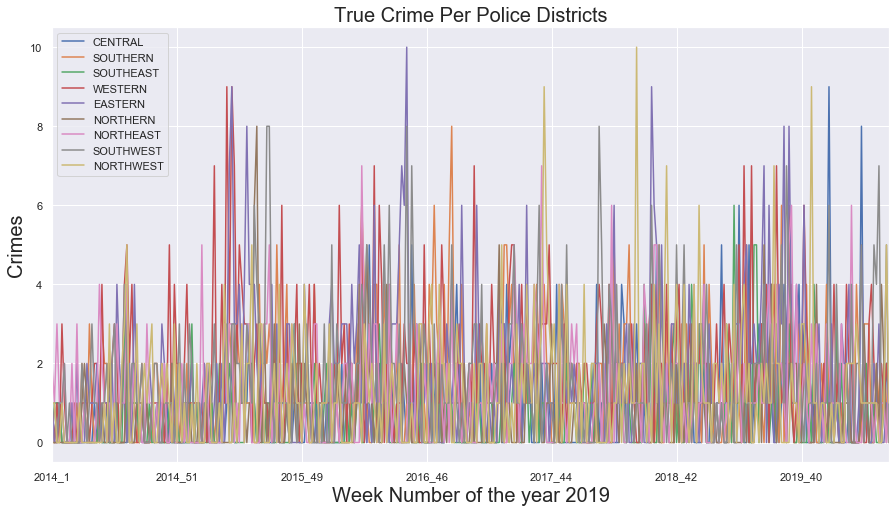

In [8]:
df = pd.DataFrame()

for i in PoliceDistrict:
    values = ts_data_week[i]['NoOfCrimes'].tolist()
    index = ts_data_week[i]['Year_Week_Number'].tolist()
    temp_df = pd.DataFrame(values, columns = [i], index = index)
    df = pd.concat([df, temp_df], axis = 1)
    

df.plot(figsize=(15,8))
plt.xlabel('Week Number of the year 2019', fontsize=20)
plt.ylabel('Crimes', fontsize=20)
plt.title('True Crime Per Police Districts', fontsize=20)
plt.savefig('../graphs/Sub_Crime/%s/policeDistrictCrimes.jpg'%crime_type)
plt.show()


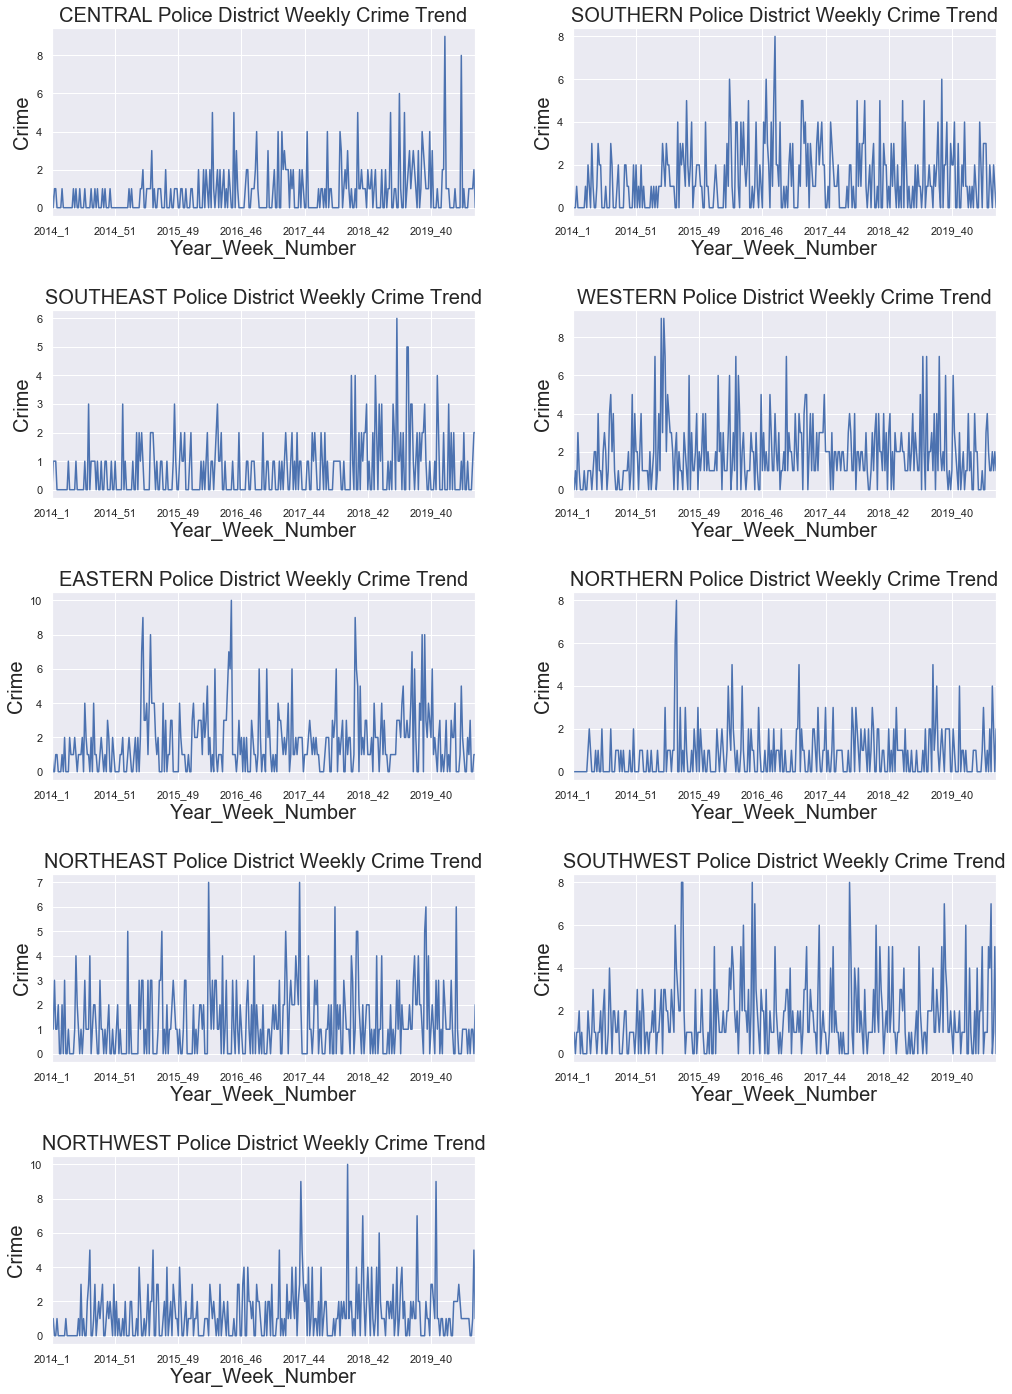

In [9]:
fig = plt.figure()
i = 0

for pd_col in df:
    ax = '52%s'%(i+1)
    axis = fig.add_subplot(int(ax))
    df[pd_col].plot(ax = axis, figsize = (15,20))
    plt.xlabel('Year_Week_Number', fontsize = 20)
    plt.ylabel('Crime', fontsize = 20)
    title = '%s Police District Weekly Crime Trend' % PoliceDistrict[i]
    plt.title(title, fontsize = 20)
    i += 1
    
fig.tight_layout(pad=3.0) 
plt.savefig('../Graphs/Sub_Crime/%s/True_Crime_Baltimre.jpg'%crime_type)

## Time Series Feature Extraction 

### Library Dependencies for making forecasting frame and Extracting time series features from it.

In [10]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features

### Takes one police district at a time and creates forecating frame and its output (total cirme) for that district and append it to a list called temp_df. 

In [11]:
df_shift = pd.DataFrame()
temp_df = []
for district in PoliceDistrict:
    temp_shift, temp_y = make_forecasting_frame(ts_data_week[district]['NoOfCrimes'], kind="crimes", max_timeshift=20, rolling_direction=1) 
    temp_df.append([temp_shift, temp_y])

### Create Time sereies features from make forecasting frames using tsfresh

In [12]:
ts_features = []

for i in temp_df:
    X = extract_features(i[0], column_id="id", column_sort="time", column_value="value", 
                             impute_function=impute, show_warnings=False)
    ts_features.append([X, i[1]])

Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


### Removing constant features

In [13]:
for i in ts_features:
    print (i[0].shape)
    i[0] = i[0].loc[:, i[0].apply(pd.Series.nunique) != 1] 
    print (i[0].shape)

(335, 754)
(335, 346)
(335, 754)
(335, 347)
(335, 754)
(335, 341)
(335, 754)
(335, 349)
(335, 754)
(335, 349)
(335, 754)
(335, 339)
(335, 754)
(335, 354)
(335, 754)
(335, 349)
(335, 754)
(335, 348)


### Adding a lag of 1 into the extraced time series feature dataframe

In [14]:
for i in ts_features:
    i[0]["feature_last_value"] = i[1].shift(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Droping the first row becuase of null value created due ot lag

In [15]:
for i in ts_features:
    i[0] = i[0].iloc[1:, ]
    i[1] = i[1].iloc[1: ]

## Training and Tesing the models
### Libray dependencies for different models and their evaluation metrics

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.utils
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

import tqdm

### Expanding Window Forecast - 
An expanding window refers to a model that train on all available historic data and uses that to make a forecast.

It is an expanding window because it grows as more real observations are collected.

#### Traing random forest regressor using expanding window forecast approach and random forest regressor performance

In [17]:
y_pred = [[np.NaN] * len(ts_features[i][1]) for i in range(len(ts_features))]

isp = 283   # index of where to start the predictions
assert isp > 0

index = 0
district = 1
for i in ts_features:
    print ("Current District Number = %s"%district)
    district += 1
    RFR = RandomForestRegressor()
    for j in tqdm.tqdm(range(isp, len(i[1]))):
        RFR.fit(i[0].iloc[:j], i[1][:j])
        y_pred[index][j] = RFR.predict(i[0].iloc[j, :].values.reshape((1, -1)))[0]
    index += 1

  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 1


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 2


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 3


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 4


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 5


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 6


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 7


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 8


  0%|          | 0/51 [00:00<?, ?it/s]

Current District Number = 9


100%|██████████| 51/51 [02:03<00:00,  2.43s/it]


In [18]:
y = []
prediction = {}
for i in range(len(temp_df)):
    y_true = np.array(temp_df[i][1].tolist())
    y_predicted = np.array(y_pred[i])
    temp = pd.DataFrame([y_true, y_predicted], index = ['True', 'Pred']).T 
    y.append(temp)
    
    dist = PoliceDistrict[i]
    temp_pred = [np.nan] + y_pred[i]
    MSE = mean_squared_error(y_true[284:], temp_pred[284:])
    MAE = mean_absolute_error(y_true[284:], temp_pred[284:])
    prediction[dist] = {'MSE': MSE, 'MAE': MAE}
    print ('Mean Squared Error for district %s = %s'%(dist, MSE))
    print ('Mean Absolute Error for district %s = %s\n\n'%(dist, MAE))

#### Finding average of MSE and MAE

total_MSE = 0
total_MAE = 0
for i in prediction:
    total_MSE += prediction[i]['MSE']
    total_MAE += prediction[i]['MAE']
    
avg_MSE = total_MSE/len(PoliceDistrict)
avg_MAE = total_MAE/len(PoliceDistrict)

print ('Average of Mean Squared Error = %s'%avg_MSE)
print ('Average of Mean Absolute Error = %s'%avg_MAE)

Mean Squared Error for district CENTRAL = 4.299558823529411
Mean Absolute Error for district CENTRAL = 1.4268627450980391


Mean Squared Error for district SOUTHERN = 2.510311764705882
Mean Absolute Error for district SOUTHERN = 1.3139215686274508


Mean Squared Error for district SOUTHEAST = 1.387441176470588
Mean Absolute Error for district SOUTHEAST = 1.0096078431372546


Mean Squared Error for district WESTERN = 3.4121784313725487
Mean Absolute Error for district WESTERN = 1.5119607843137257


Mean Squared Error for district EASTERN = 4.869974509803922
Mean Absolute Error for district EASTERN = 1.7413725490196077


Mean Squared Error for district NORTHERN = 1.7431745098039215
Mean Absolute Error for district NORTHERN = 1.0280392156862745


Mean Squared Error for district NORTHEAST = 2.6023705882352943
Mean Absolute Error for district NORTHEAST = 1.2025490196078432


Mean Squared Error for district SOUTHWEST = 4.360011764705883
Mean Absolute Error for district SOUTHWEST = 1.66078431

#### Random Forest regressor prediction visualization 

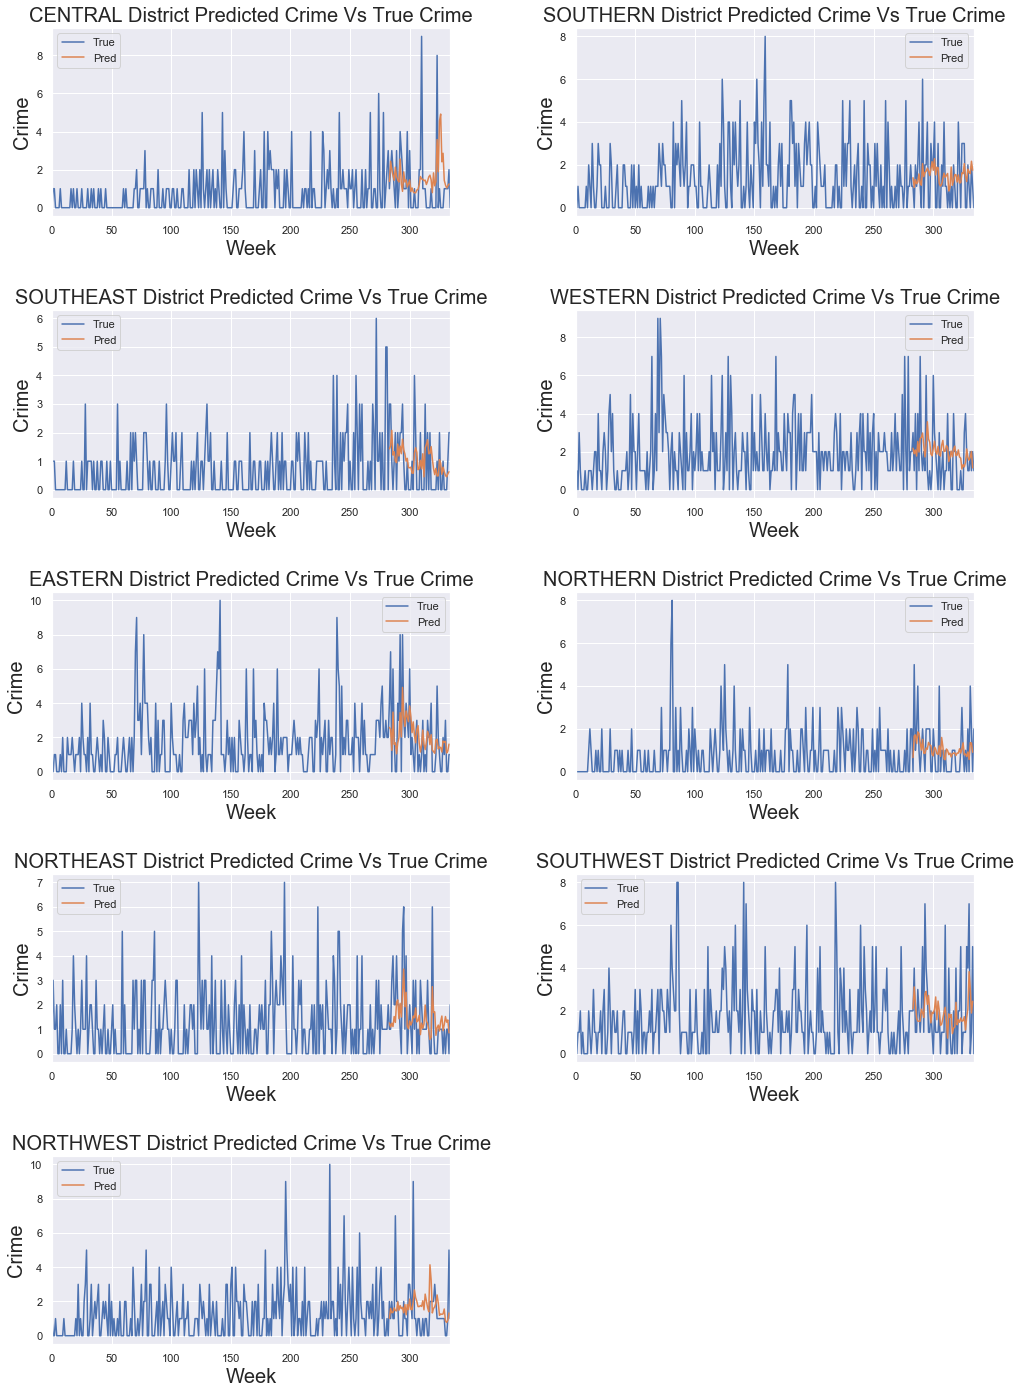

In [19]:
fig = plt.figure()

for i in range(0, 9):
    ax = '52%s'%(i+1)
    axis = fig.add_subplot(int(ax))
    y[i].plot(ax = axis, figsize = (15,20))
    plt.xlabel('Week', fontsize = 20)
    plt.ylabel('Crime', fontsize = 20)
    title = '%s District Predicted Crime Vs True Crime' % PoliceDistrict[i]
    plt.title(title, fontsize = 20)
    
fig.tight_layout(pad=3.0) 
plt.savefig('../Graphs/Sub_Crime/%s/Predicted_Crime_Vs_True_Crime_RFR.jpg'%crime_type)